
# <div style="padding:18px;color:white;margin:0;font-size:38px;text-align:center;display:fill;border-radius:20px;background-color:#4497AA;overflow:hidden">Oocular Toxoplasmosis Detection Using Xception Architecture</div>

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import os, shutil, json, zipfile, random, math
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras import callbacks
import glob
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set Matplotlib defaults
sns.set_style('darkgrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=25,
    titlepad=10,
)

# <div style="padding:18px;color:white;margin:0;font-size:30px;text-align:center;display:fill;border-radius:20px;background-color:#4497AA;overflow:hidden">1| Creating a Dataframe</div>

In [5]:
print(os.listdir("../input"))

['ocular-toxoplasmosis-fundus-images-dataset']


In [6]:
main_path = os.listdir('/kaggle/input/ocular-toxoplasmosis-fundus-images-dataset')
print(main_path)

['Data_Processed_Paper', 'Data_Raw_6class_All']


In [7]:
main_path = os.listdir('/kaggle/input/ocular-toxoplasmosis-fundus-images-dataset/Data_Processed_Paper/Data_Processed_Paper')
print(main_path)

['Diseased', 'Healthy']


In [8]:
Diseased = '/kaggle/input/ocular-toxoplasmosis-fundus-images-dataset/Data_Processed_Paper/Data_Processed_Paper/Diseased'
Healthy = '/kaggle/input/ocular-toxoplasmosis-fundus-images-dataset/Data_Processed_Paper/Data_Processed_Paper/Healthy'

In [9]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path

In [10]:
diseased_data = create_images_list(Diseased)
healthy_data = create_images_list(Healthy)


In [11]:
from sklearn.utils import shuffle

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
from sklearn.model_selection import train_test_split

In [42]:
df = pd.concat([ pd.DataFrame({ 'image' : healthy_data, 'class': 'Healthy'}),
                              pd.DataFrame({ 'image' : diseased_data, 'class': 'Diseased'})], ignore_index = True)

df = shuffle(df, random_state = 42).reset_index(drop = True)

train_set, test_set= train_test_split(df,test_size = 0.2, stratify = df['class'] )

In [16]:
print("train images: ", train_set.shape[0])
print("test images: ", test_set.shape[0])

train images:  328
test images:  83


# <div style="padding:18px;color:white;margin:0;font-size:30px;text-align:center;display:fill;border-radius:20px;background-color:#4497AA;overflow:hidden">2| Viewing Sample Images</div>

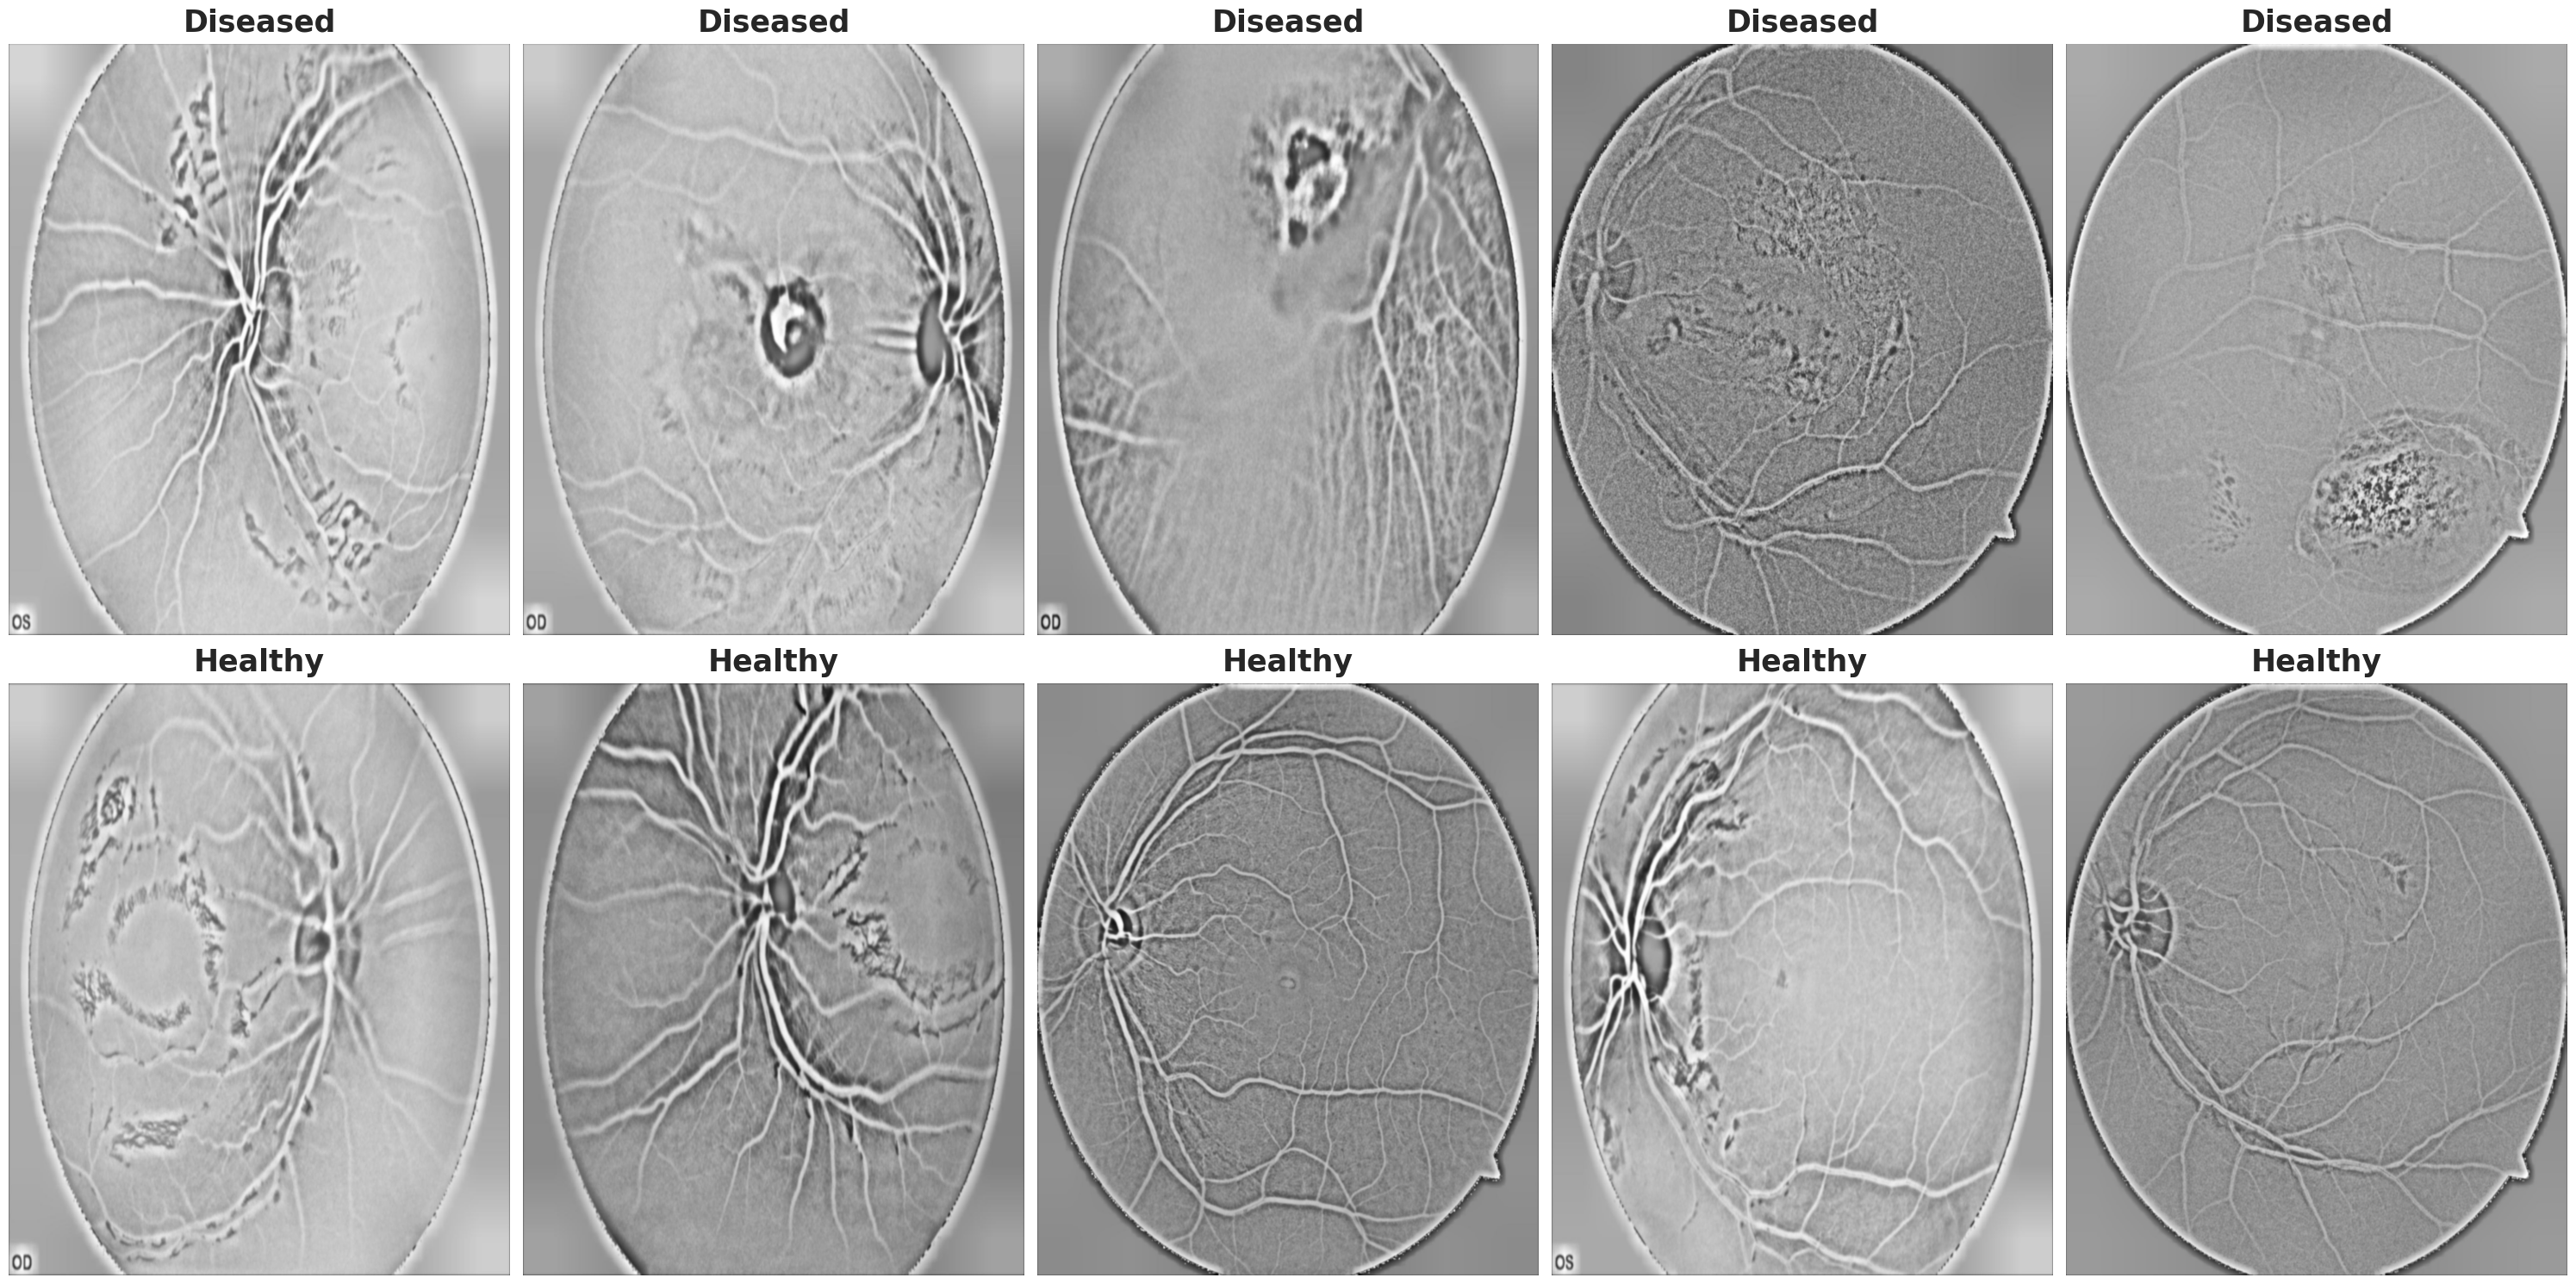

In [17]:
# Get few samples for both the classes
diseased = (train_set[train_set['class']=="Diseased"]['image'].iloc[:5]).tolist()
healthy = (train_set[train_set['class']=="Healthy"]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = diseased + healthy
del diseased, healthy
#plt.rcParams['font.size'] = 15
# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,15))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img)
    if i<5:
        ax[i//5, i%5].set_title("Diseased")
    else:
        ax[i//5, i%5].set_title("Healthy")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [18]:
# Get the counts for each class
train_cases_count = train_set['class'].value_counts()
print(train_cases_count)

class
Diseased    223
Healthy     105
Name: count, dtype: int64


In [19]:
# Get the counts for each class
test_cases_count = test_set['class'].value_counts()
print(test_cases_count)

class
Diseased    56
Healthy     27
Name: count, dtype: int64


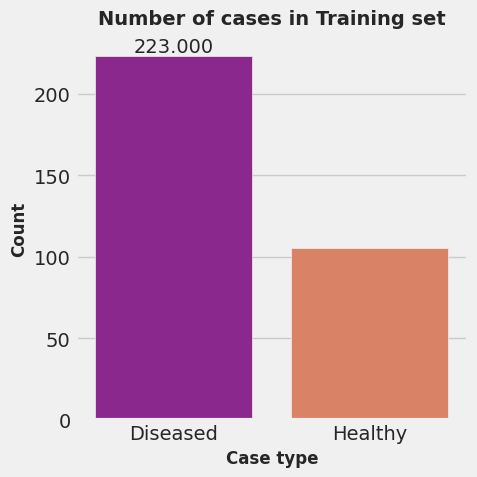

In [71]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=train_cases_count.index, y= train_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Training set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_cases_count.index)), ['Diseased', 'Healthy'])
plt.show();

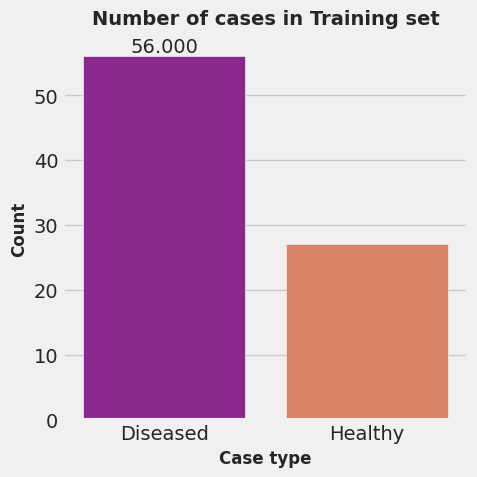

In [72]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=test_cases_count.index, y= test_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Training set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_cases_count.index)), ['Diseased', 'Healthy'])
plt.show()

# <div style="padding:18px;color:white;margin:0;font-size:30px;text-align:center;display:fill;border-radius:20px;background-color:#4497AA;overflow:hidden">3| Data Agumentation</div>

In [23]:
IMG_SIZE = (224, 224)
BATCH = 32
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_set,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = 42)

ds_test = test_datagen.flow_from_dataframe(test_set,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = 42)

In [47]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

# <div style="padding:18px;color:white;margin:0;font-size:30px;text-align:center;display:fill;border-radius:20px;background-color:#4497AA;overflow:hidden">3| Modelling</div>

In [53]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers

# Load the pretrained Xception model
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMG_SIZE, 3])

# Set the pretrained model to be trainable
pretrained_model.trainable = True

# Create the model
model = tf.keras.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(256, kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Activation('elu'),
    Dropout(0.5),

    Dense(128, kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Activation('elu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_16 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [54]:
hist = model.fit(ds_train, epochs = 10, validation_data = ds_test,
                 batch_size = BATCH_SIZE, callbacks=[early_stopping, plateau])

Epoch 1/10
11/11 [==============================] - 352s 30s/step - loss: 6.8222 - auc: 0.7802 - precision: 0.5479 - recall: 0.7619 - val_loss: 7.1351 - val_auc: 0.8148 - val_precision: 0.3418 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - 324s 29s/step - loss: 5.9555 - auc: 0.9195 - precision: 0.7864 - recall: 0.7714 - val_loss: 8.9113 - val_auc: 0.7232 - val_precision: 0.3253 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 5.2409 - auc: 0.9578 - precision: 0.7815 - recall: 0.8857 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
11/11 [==============================] - 321s 31s/step - loss: 5.2409 - auc: 0.9578 - precision: 0.7815 - recall: 0.8857 - val_loss: 13.3224 - val_auc: 0.5089 - val_precision: 0.3253 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - 322s 29s/step - loss: 4.7456 - auc: 0.9484 - precision: 0.9545 - recall: 

In [65]:
# Set Matplotlib defaults
sns.set_style('darkgrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=15,
    titlepad=10,
)

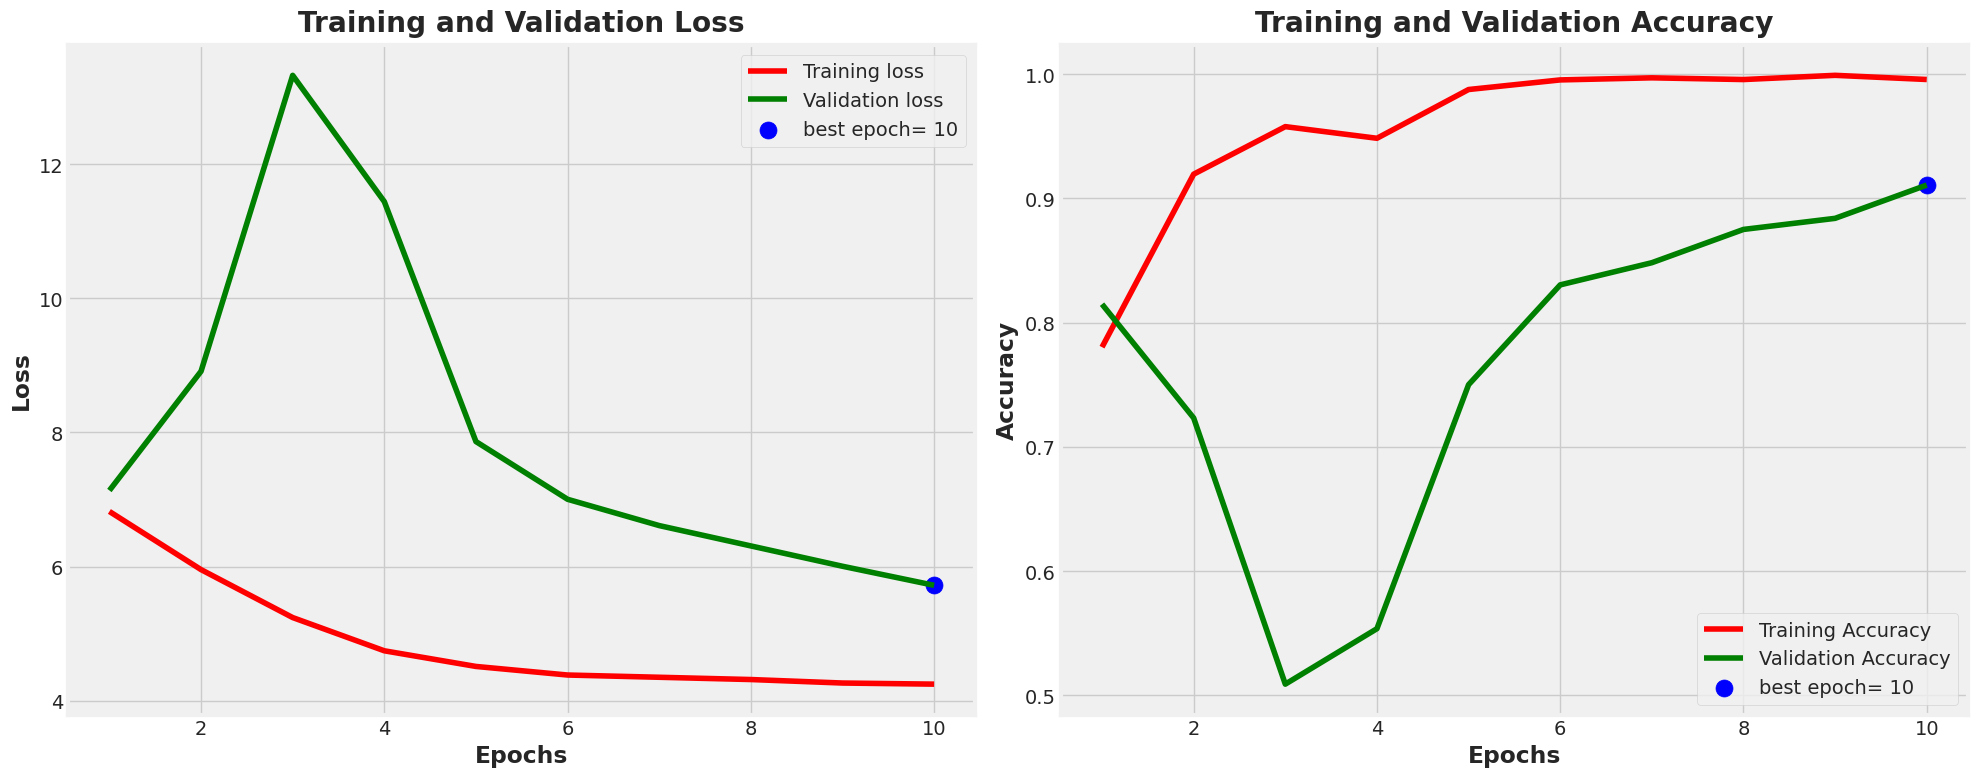

In [67]:
# Define needed variables
tr_acc = hist.history['auc']
tr_loss = hist.history['loss']
val_acc = hist.history['val_auc']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [73]:
preds = model.predict_generator(ds_test)
y_pred = np.argmax(preds, axis=1)

In [76]:
test_eval = model.evaluate(ds_test)
print('Test Loss: {0:.3f}'.format(test_eval[0]))
print('Test AUC: {0:.3f}'.format(test_eval[1]))
print('Test Precision: {0:.3f}'.format(test_eval[2]))
print('Test Recall: {0:.3f}'.format(test_eval[3]))

3/3 [==============================] - 21s 6s/step - loss: 5.7214 - auc: 0.9107 - precision: 0.4500 - recall: 1.0000
Test Loss: 5.721
Test AUC: 0.911
Test Precision: 0.450
Test Recall: 1.000
